In [1]:
%load_ext autoreload
%autoreload 2


In [8]:
import src.urban_diff_helper as ud_helper
import pandas as pd
from scipy.stats import wilcoxon,ttest_rel,kendalltau, spearmanr

In [9]:
import numpy as np

In [10]:
from IPython.display import display

In [11]:
import matplotlib.pyplot as plt

# load geometries

In [12]:
zms, zms_agebs, zms_tvor, zms_grids, mg_mappings = ud_helper.load_geoms()

loading zms
loading agebs
loading voronoi
loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
==================== loading grids False False 2019-11-22 22:56:32.865359
=====computing mpa_grids
reading existing grids
==================== loading grids False True 2019-11-22 22:58:20.688540
loading existing file data/mexico/geography-socioeconomics/2010MetropolitanAreas/grids_500_whole_urb.geojson.gz
==================== loading grids True False 2019-11-22 22:58:25.322545
loading existing file data/mexico/geography-socioeconomics/2010MetropolitanAreas/grids_500_perMun_uNr.geojson.gz
==================== loading grids True True 2019-11-22 22:59:06.871114
loading existing file data/mexico/geography-socioeconomics/2010MetropolitanAreas/grids_500_perMun_urb.geojson.gz


In [52]:

zms_sub_vors = {}
for per_mun in [False, True]:
    for urb_only in [False, True]:
#         print('=' * 20, 'loading grids', per_mun, urb_only, dt.datetime.now())
        zms_sub_vors[(per_mun, urb_only)] = ud_helper.region.mpa_vors(per_mun, urb_only)

loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
computing the intersection between p1 tower and p2 CVE_SUN
len(p1)=5731 > 10 * len(p2)=59, swap them
computing area of the intersections
computing the weight
loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
computing the intersection between p1 tower and p2 CVE_SUN
len(p1)=5731 > 10 * len(p2)=59, swap them
computing area of the intersections
computing the weight
loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
computing the intersection between p1 tower and p2 mun_id
len(p1)=5731 > 10 * len(p2)=367, swap them
computing area of the intersections
computing the weight
loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
computing the intersection between p1 tower and p2 mun_id
len(p1)=5731 > 10 * len(p2)=367, swap them
computing area of the intersections
computing the weight


# load interpolation and interpolate avg

In [13]:
avg_tw, avg_a, avg_g, avg_idw = ud_helper.interpolation(zms_grids)

loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out+in.pickle
to_map_agebs loading existing file data/mex_tw_intpl/tower_to_mpa_agebs_by_area.csv
to_map_agebs loading existing file data/mex_tw_intpl/tower_to_mpa_agebs_by_pop.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_whole_uNr_area.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_whole_urb_area.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_uNr_area.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_urb_area.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_whole_uNr_pop.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_whole_urb_pop.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_uNr_pop.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_urb_pop.csv
interpolate_idw loading existing file

In [61]:

avg_vor = {}
for by in ['area', 'pop']:
    for per_mun in [False, True]:
        for urb_only in [False, True]:
            sub_vors = zms_sub_vors[(per_mun, urb_only)]
            t2v = ud_helper.tw_int.to_mpa_vors(by=by, per_mun=per_mun, urb_only=urb_only, zms_vors=sub_vors)
            t2v.set_index('vor', inplace=True)
            avg_vor[(by, per_mun, urb_only)] = ud_helper.tw_int.interpolate_stats(avg_tw, t2v)


computing to_map_vors area False False
computing to_map_vors area False True
computing to_map_vors area True False
computing to_map_vors area True True
to_mpa_vors loading existing file data/mex_tw_intpl/tower_to_mpa_vors_whole_uNr_pop.csv
to_mpa_vors loading existing file data/mex_tw_intpl/tower_to_mpa_vors_whole_urb_pop.csv
to_mpa_vors loading existing file data/mex_tw_intpl/tower_to_mpa_vors_perMun_uNr_pop.csv
to_mpa_vors loading existing file data/mex_tw_intpl/tower_to_mpa_vors_perMun_urb_pop.csv


# statistics test

In [62]:
def sig_lvl(x):
    if x==-1 or x==0:
        return '-'
    if x <0.001:
        return '***'
    if x<0.01:
        return '**'
    if x<0.05:
        return '*'
    return ''

In [63]:
def statistics_test(test_func, stat_df, clean_table=False, larger_than=0.0):

    n_cols = stat_df.shape[1]
    p_values = np.zeros((n_cols, n_cols))
    test_measures = np.ones((n_cols, n_cols))
    for i in range(n_cols):
        for j in range(i + 1, n_cols):
            m, p = test_func(stat_df.iloc[:, i], stat_df.iloc[:, j])
            p_values[i, j] = p_values[j, i] = p
            test_measures[i, j] = test_measures[j, i] = m

    
    p_values = pd.DataFrame(p_values,
                          index=stat_df.columns,
                          columns=stat_df.columns)
    test_measures[test_measures<=larger_than] = 0
    test_measures = pd.DataFrame(test_measures,
                          index=stat_df.columns,
                          columns=stat_df.columns)
    
    if clean_table:
        p_values = p_values.applymap(sig_lvl)
#         test_measures = test_measures.applymap(lambda x: f'{x:.3f}')
    return p_values, test_measures

wilcoxon_test = lambda stat_df, clean_table, larger_than: statistics_test(wilcoxon, stat_df, clean_table, larger_than)
paired_t_test = lambda stat_df, clean_table, larger_than: statistics_test(ttest_rel, stat_df, clean_table, larger_than)
ken_tau_corr = lambda stat_df, clean_table, larger_than: statistics_test(kendalltau, stat_df, clean_table, larger_than)
spe_rho_corr = lambda stat_df, clean_table, larger_than: statistics_test(spearmanr, stat_df, clean_table, larger_than)

# draw function

In [64]:
import plotly.offline as offline
offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go

In [65]:
def draw_scatter(data_df, mode='lines+markers',height=600,margin_r=100):
    
    data = [
        go.Scatter(x='zm' + data_df.index.astype(str),
                   y=data_df[intpl_type].tolist(),
                   name=str(intpl_type),
                   mode='lines+markers'
                  ) for intpl_type in data_df
    ]
    fig = go.Figure()
    for trace in data:
        fig.add_trace(trace)
    fig.update_layout(height=height,margin=dict(l=10, r=margin_r, t=10, b=10),)

    offline.iplot(fig)

In [66]:
import matplotlib.pyplot as plt
from matplotlib import colors

def background_gradient(s, m=None, M=None,  cmap='Oranges', low=0, high=0.2):

    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]


In [67]:
swap = lambda df, i, j: df.swaplevel(i,j).T.swaplevel(i,j).sort_index(level=range(len(df.columns.levels))).T.sort_index(level=range(len(df.columns.levels)))

In [68]:
from IPython.core.display import HTML 

In [978]:
def grad_bg(df, cmap='Oranges', mini=None, maxi=None, high=0, mask_tril=False,format_float=True):
    if mini is None:
        mini = df.min().min()
    if maxi is None:
        maxi = df.max().max()
    if mask_tril:
        df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_),-1))
    format_str = "{:.3f}" if format_float else "{:.0f}"
    style= df.style.apply(background_gradient, m=mini, M=maxi, cmap=cmap, high=high).format(format_str).set_table_attributes("style='display:inline'")
    return HTML(style.render().replace('nan',''))

# urban dilatation index

In [20]:
# compute
print('computing dv_a')
dv_a = {}
for by, avg in avg_a.items():
    dv_a[by] = ud_helper.dilatation.dv_for_mpa_ageb(avg, zms, zms_agebs)

print('computing dv_g')
dv_g = {}
for (side, by, per_mun), avg in avg_g.items():
    zms_g = zms_grids[(side, per_mun)]
    dv_g[(side, by, per_mun)] = ud_helper.dilatation.dv_for_mpa_grids(avg, zms, zms_g)

print('computing dv_idw')
dv_idw = {}
for key, avg in avg_idw.items():
    zms_g = zms_grids[key]
    dv_idw[key] = ud_helper.dilatation.dv_for_mpa_grids(avg, zms, zms_g)

computing dv_a
computing dv_g
computing dv_idw


In [437]:
# flatten the dictionary of stats
var = 'dilatation coefficient'
a = {('ageb', 'area'):dv_a['area'][var], ('ageb', 'pop') : dv_a['pop'][var]}
g= {(f'g{side//1000}', by, ):dv[var] for (side, by, per_mun), dv in dv_g.items() if not per_mun}
idw= {(f'g{side//1000}','_idw') :dv[var] for (side, per_mun), dv in dv_idw.items() if not per_mun}
dila_coef = pd.DataFrame({**a, **g, **idw})

In [278]:
# Visualization
sort_col = ud_helper.zms_sort_cols[0]
dila_coef = dila_coef.loc[zms.sort_values(sort_col).index]

# sort_col = dila_coef.columns[0]
# dila_coef=dila_coef.sort_values(sort_col)
# print(sort_col)

draw_scatter(dila_coef, height=300)
draw_scatter(dila_coef.std(axis=1).to_frame(), height=300, margin_r=135)

In [460]:
64*59

3776

In [456]:
# even though (ageb, pop) and (g1 pop) has similar values, 
# but the std could also be small.
dila_wil_ps, _ = wilcoxon_test(dila_coef, clean_table=False)
grad_bg(dila_wil_ps, cmap='PuBu',high=.2)
# dila_wil_ps

In [470]:
dila_ken_ps, dila_ken_tau = ken_tau_corr(
    dila_coef, clean_table=False, larger_than=0.8)
print()
grad_bg(dila_ken_ps, cmap='PuBu',high=.2)

In [471]:
grad_bg(swap(dila_ken_tau,0,1))

In [472]:
grad_bg(swap(swap(dila_ken_tau,0,1),0,1))

# hotspots

In [605]:
loading = ('ageb', 'grid', 'idw', 'vor')
hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor, hs_stats_tw = ud_helper.compute_hotspot_stats(
    avg_a, avg_g, avg_idw, avg_tw, avg_vor,
    zms, zms_agebs, zms_grids,zms_sub_vors,mg_mappings,
    hs_type='loubar',loading=loading)

('area', False, False) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
('area', False, True) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
('area', True, False) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
('area', True, True) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
('pop', False, False) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 

## inter metro measurements correlation Kendall, spearmanr

In [109]:
from src.urban_diff_helper import ADMIN_STR

In [183]:
def inter_metro_measurement(zms, hs_stats, geom_type, measure_type, time_range=None,measure_name=None,idw=False):
    measures = {}
    if type(hs_stats) is dict:
        for key, stats in hs_stats.items():
            if not idw:
                by, per_mun, urb_only = key
            else:
                by = '_idw10'
                per_mun, urb_only = key
                
            if time_range is None: 
                # for number of average hotspot
                measures[(ADMIN_STR(per_mun, urb_only), geom_type, by)] = [
                    stats[measure_type][sun]['average'] for sun in zms.index
                ]                
            else:
                # for compactness
                measures[(ADMIN_STR(per_mun, urb_only), geom_type, by)] = [
                    stats[measure_type][sun][time_range][measure_name] for sun in zms.index
                ]
                
    elif type(hs_stats) is list:
        assert len(hs_stats) == len(geom_type) == len(idw)
        for hstat, gtype, is_idw in zip(hs_stats, geom_type, idw):
            measures.update(inter_metro_measurement(zms, hstat, gtype, measure_type, time_range, measure_name, is_idw))
    return measures

In [606]:
hs_stats = [hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor]
geom_types = ['ageb', 'g.5km', 'g.5km', 'vor']
idws = [False, False, True,False]
compactness_indexes = {}
for measure_name in ['comp_coef', 'cohesion', 'proximity','NMI','NMMI']:
    for time_range in ['all_day', 'home_time', 'work_time']:
        compact = inter_metro_measurement(zms, hs_stats, geom_types, 'compactness', time_range, measure_name, idws)
        compact =  pd.DataFrame(compact)
        compactness_indexes[(measure_name, time_range)] = compact

comp_ken_tau= []
comp_spr_rho = []
for (measure_name, time_range), compact in compactness_indexes.items():
    key_str = (measure_name + '<br>' + time_range).replace('_',' ')
    p_values, taus = ken_tau_corr(compact, clean_table=False,larger_than=.0)
    comp_ken_tau.append((key_str, taus))
    p_values, rhos = spe_rho_corr(compact, clean_table=False,larger_than=.0)
    comp_spr_rho.append((key_str, rhos))

In [607]:
hs_stats = [hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor]
geom_types = ['ageb', 'g.5km', 'g.5km', 'vor']
idws = [False, False, True,False]
average_number_hotspot = pd.DataFrame(inter_metro_measurement(zms, hs_stats, geom_types, 'n_hs', idw=idws))

nhs_spr_ps, nhs_spr_rho = spe_rho_corr(average_number_hotspot, clean_table=False,larger_than=0.0)
nhs_ken_ps, nhs_ken_tau = ken_tau_corr(average_number_hotspot, clean_table=False,larger_than=0.0)


### table and plots of the correlations

#### compactness

In [170]:
comp_ken_ps, comp_ken_tau = ken_tau_corr(comp_coef, clean_table=False,larger_than=.0)
comp_spr_ps, comp_spr_rho = spe_rho_corr(comp_coef, clean_table=False, larger_than=.0)

In [219]:
comp_work_ken_ps, comp_work_ken_tau = ken_tau_corr(comp_coef_work, clean_table=False,larger_than=.0)
comp_work_spr_ps, comp_work_spr_rho = spe_rho_corr(comp_coef_work, clean_table=False, larger_than=.0)

In [220]:
comp_home_ken_ps, comp_home_ken_tau = ken_tau_corr(comp_coef_home, clean_table=False,larger_than=.0)
comp_home_spr_ps, comp_home_spr_rho = spe_rho_corr(comp_coef_home, clean_table=False, larger_than=.0)

In [40]:

swap_df = comp_ken_tau

display(grad_bg(swap_df.T.sort_index(level=0).T.sort_index(level=0), mask_tril=True))

# swap_df = swap(swap_df, 0,2)
# # display(grad_bg(swap_df))
# swap_df = swap(swap_df, 1,2)
# display(grad_bg(swap_df))

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



In [236]:


sort_col = ud_helper.zms_sort_cols[3]
comp_coef = comp_coef.loc[zms.sort_values(sort_col).index]
sort_col = comp_coef.columns[0]
comp_coef=comp_coef.sort_values(sort_col)
print(sort_col)

draw_scatter(comp_coef, height=300)
draw_scatter(comp_coef.std(axis=1).to_frame(), height=300, margin_r=175)

('whole_uNr', 'ageb', 'area')


#### for N hotspot

In [379]:
# display(grad_bg(nhs_ken_tau.T.sort_index(level=0).T.sort_index(level=0),mini=0))

# swap_df = swap(nhs_ken_tau, 0,2)
# display(grad_bg(swap_df))

# swap_df = swap(swap_df, 1,2)
# display(grad_bg(swap_df))
# swap_df = swap(swap_df, 2,0)
# display(grad_bg(swap_df))

In [288]:

sort_col = Mean_number_hot.columns[0]
Mean_number_hot=Mean_number_hot.sort_values(sort_col)
print(sort_col)

draw_scatter(Mean_number_hot)

('ageb', nan, 'area', 'zm')


### display table

#### method-level pairwise corr
4 big table(Admin-bound); small table: per index, corr between methods

In [608]:
admin_strs = [ADMIN_STR(m,u) for m in [False, True] for u in [False,True]]

In [609]:
def print_table(astr, measurements):
    print(astr.replace('_','\n'))
    for index_name, index_corr in measurements:
        tbl = index_corr.T.sort_index(level=0).T.sort_index(level=0).loc[astr, astr].copy()
        tbl.columns =['<br/>'.join(col).strip() for col in tbl.columns.values]
        tbl.index =['<br/>'.join(col).strip() for col in tbl.index.values]
        tbl.index.name=index_name
        dis_tbl = grad_bg(tbl, mask_tril=True, mini=0)
        display(dis_tbl)

In [616]:
i=3
astr=admin_strs[i]
measurements = [('Avg N HS', nhs_ken_tau)]+comp_ken_tau
print_table(astr, measurements)

PerMun
Urban


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
Avg N HS,,,,,,,
agebarea,1.000,0.780,0.586,0.648,0.727,0.763,0.708
agebpop,,1.000,0.525,0.604,0.704,0.744,0.712
g.5km_idw10,,,1.000,0.676,0.698,0.600,0.567
g.5kmarea,,,,1.000,0.801,0.587,0.545
g.5kmpop,,,,,1.000,0.672,0.639
vorarea,,,,,,1.000,0.904
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
comp coefall day,,,,,,,
agebarea,1.000,0.619,0.607,0.755,0.576,0.598,0.536
agebpop,,1.000,0.640,0.640,0.735,0.457,0.580
g.5km_idw10,,,1.000,0.736,0.693,0.591,0.529
g.5kmarea,,,,1.000,0.721,0.645,0.569
g.5kmpop,,,,,1.000,0.529,0.694
vorarea,,,,,,1.000,0.632
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
comp coefhome time,,,,,,,
agebarea,1.000,0.628,0.610,0.756,0.576,0.597,0.518
agebpop,,1.000,0.642,0.650,0.756,0.484,0.584
g.5km_idw10,,,1.000,0.744,0.702,0.604,0.544
g.5kmarea,,,,1.000,0.729,0.654,0.573
g.5kmpop,,,,,1.000,0.525,0.681
vorarea,,,,,,1.000,0.639
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
comp coefwork time,,,,,,,
agebarea,1.000,0.633,0.617,0.744,0.594,0.595,0.496
agebpop,,1.000,0.689,0.662,0.805,0.450,0.653
g.5km_idw10,,,1.000,0.742,0.756,0.562,0.622
g.5kmarea,,,,1.000,0.738,0.608,0.539
g.5kmpop,,,,,1.000,0.493,0.677
vorarea,,,,,,1.000,0.581
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
cohesionall day,,,,,,,
agebarea,1.000,0.513,0.336,0.570,0.357,0.527,0.397
agebpop,,1.000,0.534,0.494,0.721,0.404,0.548
g.5km_idw10,,,1.000,0.507,0.600,0.379,0.411
g.5kmarea,,,,1.000,0.584,0.578,0.479
g.5kmpop,,,,,1.000,0.410,0.610
vorarea,,,,,,1.000,0.531
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
cohesionhome time,,,,,,,
agebarea,1.000,0.509,0.330,0.555,0.350,0.590,0.395
agebpop,,1.000,0.531,0.470,0.724,0.468,0.568
g.5km_idw10,,,1.000,0.486,0.578,0.390,0.393
g.5kmarea,,,,1.000,0.545,0.579,0.426
g.5kmpop,,,,,1.000,0.445,0.614
vorarea,,,,,,1.000,0.620
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
cohesionwork time,,,,,,,
agebarea,1.000,0.518,0.345,0.551,0.428,0.608,0.377
agebpop,,1.000,0.514,0.514,0.777,0.452,0.634
g.5km_idw10,,,1.000,0.441,0.562,0.372,0.522
g.5kmarea,,,,1.000,0.615,0.627,0.480
g.5kmpop,,,,,1.000,0.490,0.710
vorarea,,,,,,1.000,0.575
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
proximityall day,,,,,,,
agebarea,1.000,0.502,0.342,0.545,0.389,0.490,0.351
agebpop,,1.000,0.510,0.449,0.695,0.385,0.524
g.5km_idw10,,,1.000,0.437,0.523,0.328,0.373
g.5kmarea,,,,1.000,0.565,0.564,0.430
g.5kmpop,,,,,1.000,0.407,0.631
vorarea,,,,,,1.000,0.531
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
proximityhome time,,,,,,,
agebarea,1.000,0.492,0.348,0.571,0.387,0.535,0.370
agebpop,,1.000,0.494,0.460,0.707,0.447,0.535
g.5km_idw10,,,1.000,0.435,0.507,0.357,0.344
g.5kmarea,,,,1.000,0.522,0.578,0.416
g.5kmpop,,,,,1.000,0.458,0.632
vorarea,,,,,,1.000,0.604
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
proximitywork time,,,,,,,
agebarea,1.000,0.499,0.328,0.536,0.420,0.589,0.363
agebpop,,1.000,0.486,0.493,0.784,0.431,0.635
g.5km_idw10,,,1.000,0.387,0.494,0.307,0.453
g.5kmarea,,,,1.000,0.608,0.594,0.465
g.5kmpop,,,,,1.000,0.481,0.714
vorarea,,,,,,1.000,0.578
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMIall day,,,,,,,
agebarea,1.000,0.513,0.336,0.570,0.357,0.527,0.397
agebpop,,1.000,0.534,0.494,0.721,0.404,0.548
g.5km_idw10,,,1.000,0.507,0.600,0.379,0.411
g.5kmarea,,,,1.000,0.584,0.578,0.479
g.5kmpop,,,,,1.000,0.410,0.610
vorarea,,,,,,1.000,0.531
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMIhome time,,,,,,,
agebarea,1.000,0.509,0.330,0.555,0.350,0.590,0.395
agebpop,,1.000,0.531,0.470,0.724,0.468,0.568
g.5km_idw10,,,1.000,0.486,0.578,0.390,0.393
g.5kmarea,,,,1.000,0.545,0.579,0.426
g.5kmpop,,,,,1.000,0.445,0.614
vorarea,,,,,,1.000,0.620
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMIwork time,,,,,,,
agebarea,1.000,0.518,0.345,0.551,0.428,0.608,0.377
agebpop,,1.000,0.514,0.514,0.777,0.452,0.634
g.5km_idw10,,,1.000,0.441,0.562,0.372,0.522
g.5kmarea,,,,1.000,0.615,0.627,0.480
g.5kmpop,,,,,1.000,0.490,0.710
vorarea,,,,,,1.000,0.575
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMMIall day,,,,,,,
agebarea,1.000,0.437,0.286,0.617,0.382,0.537,0.288
agebpop,,1.000,0.496,0.472,0.807,0.462,0.564
g.5km_idw10,,,1.000,0.375,0.502,0.342,0.371
g.5kmarea,,,,1.000,0.461,0.631,0.384
g.5kmpop,,,,,1.000,0.440,0.645
vorarea,,,,,,1.000,0.382
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMMIhome time,,,,,,,
agebarea,1.000,0.420,0.295,0.627,0.376,0.570,0.330
agebpop,,1.000,0.513,0.466,0.808,0.474,0.608
g.5km_idw10,,,1.000,0.383,0.520,0.365,0.395
g.5kmarea,,,,1.000,0.477,0.662,0.434
g.5kmpop,,,,,1.000,0.467,0.702
vorarea,,,,,,1.000,0.438
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMMIwork time,,,,,,,
agebarea,1.000,0.424,0.309,0.638,0.416,0.571,0.315
agebpop,,1.000,0.502,0.459,0.835,0.455,0.672
g.5km_idw10,,,1.000,0.349,0.531,0.373,0.494
g.5kmarea,,,,1.000,0.493,0.629,0.364
g.5kmpop,,,,,1.000,0.475,0.715
vorarea,,,,,,1.000,0.442
vorpop,,,,,,,1.000


In [623]:
i = 3
astr = admin_strs[i]
measurements = [('Avg N HS', nhs_spr_rho)]+comp_spr_rho
print_table(astr, measurements)

PerMun
Urban


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
Avg N HS,,,,,,,
agebarea,1.000,0.926,0.782,0.826,0.896,0.915,0.875
agebpop,,1.000,0.708,0.781,0.875,0.896,0.882
g.5km_idw10,,,1.000,0.843,0.838,0.763,0.732
g.5kmarea,,,,1.000,0.931,0.752,0.705
g.5kmpop,,,,,1.000,0.850,0.814
vorarea,,,,,,1.000,0.983
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
comp coefall day,,,,,,,
agebarea,1.000,0.751,0.813,0.915,0.742,0.720,0.655
agebpop,,1.000,0.814,0.776,0.863,0.586,0.715
g.5km_idw10,,,1.000,0.903,0.845,0.778,0.699
g.5kmarea,,,,1.000,0.854,0.793,0.719
g.5kmpop,,,,,1.000,0.686,0.868
vorarea,,,,,,1.000,0.741
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
comp coefhome time,,,,,,,
agebarea,1.000,0.754,0.815,0.916,0.747,0.724,0.645
agebpop,,1.000,0.827,0.782,0.883,0.610,0.724
g.5km_idw10,,,1.000,0.911,0.853,0.790,0.713
g.5kmarea,,,,1.000,0.857,0.807,0.720
g.5kmpop,,,,,1.000,0.691,0.853
vorarea,,,,,,1.000,0.748
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
comp coefwork time,,,,,,,
agebarea,1.000,0.773,0.804,0.906,0.759,0.721,0.612
agebpop,,1.000,0.865,0.821,0.938,0.601,0.824
g.5km_idw10,,,1.000,0.898,0.907,0.739,0.775
g.5kmarea,,,,1.000,0.876,0.769,0.678
g.5kmpop,,,,,1.000,0.653,0.846
vorarea,,,,,,1.000,0.670
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
cohesionall day,,,,,,,
agebarea,1.000,0.603,0.472,0.727,0.472,0.691,0.539
agebpop,,1.000,0.705,0.626,0.881,0.539,0.698
g.5km_idw10,,,1.000,0.661,0.770,0.511,0.566
g.5kmarea,,,,1.000,0.698,0.762,0.625
g.5kmpop,,,,,1.000,0.549,0.767
vorarea,,,,,,1.000,0.656
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
cohesionhome time,,,,,,,
agebarea,1.000,0.614,0.460,0.728,0.461,0.752,0.537
agebpop,,1.000,0.695,0.620,0.880,0.597,0.708
g.5km_idw10,,,1.000,0.626,0.738,0.535,0.545
g.5kmarea,,,,1.000,0.672,0.764,0.570
g.5kmpop,,,,,1.000,0.584,0.762
vorarea,,,,,,1.000,0.750
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
cohesionwork time,,,,,,,
agebarea,1.000,0.604,0.477,0.700,0.534,0.758,0.485
agebpop,,1.000,0.669,0.650,0.921,0.597,0.799
g.5km_idw10,,,1.000,0.582,0.724,0.505,0.674
g.5kmarea,,,,1.000,0.731,0.807,0.618
g.5kmpop,,,,,1.000,0.646,0.868
vorarea,,,,,,1.000,0.700
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
proximityall day,,,,,,,
agebarea,1.000,0.597,0.478,0.716,0.518,0.644,0.497
agebpop,,1.000,0.672,0.590,0.859,0.512,0.681
g.5km_idw10,,,1.000,0.584,0.688,0.449,0.509
g.5kmarea,,,,1.000,0.686,0.745,0.571
g.5kmpop,,,,,1.000,0.541,0.810
vorarea,,,,,,1.000,0.662
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
proximityhome time,,,,,,,
agebarea,1.000,0.605,0.474,0.738,0.516,0.703,0.506
agebpop,,1.000,0.654,0.610,0.877,0.574,0.681
g.5km_idw10,,,1.000,0.569,0.669,0.487,0.474
g.5kmarea,,,,1.000,0.653,0.748,0.543
g.5kmpop,,,,,1.000,0.593,0.808
vorarea,,,,,,1.000,0.738
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
proximitywork time,,,,,,,
agebarea,1.000,0.586,0.440,0.687,0.515,0.747,0.453
agebpop,,1.000,0.634,0.641,0.923,0.574,0.807
g.5km_idw10,,,1.000,0.524,0.656,0.435,0.602
g.5kmarea,,,,1.000,0.725,0.782,0.614
g.5kmpop,,,,,1.000,0.641,0.884
vorarea,,,,,,1.000,0.709
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMIall day,,,,,,,
agebarea,1.000,0.603,0.472,0.727,0.472,0.691,0.539
agebpop,,1.000,0.705,0.626,0.881,0.539,0.698
g.5km_idw10,,,1.000,0.661,0.770,0.511,0.566
g.5kmarea,,,,1.000,0.698,0.762,0.625
g.5kmpop,,,,,1.000,0.549,0.767
vorarea,,,,,,1.000,0.656
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMIhome time,,,,,,,
agebarea,1.000,0.614,0.460,0.728,0.461,0.752,0.537
agebpop,,1.000,0.695,0.620,0.880,0.597,0.708
g.5km_idw10,,,1.000,0.626,0.738,0.535,0.545
g.5kmarea,,,,1.000,0.672,0.764,0.570
g.5kmpop,,,,,1.000,0.584,0.762
vorarea,,,,,,1.000,0.750
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMIwork time,,,,,,,
agebarea,1.000,0.604,0.477,0.700,0.534,0.758,0.485
agebpop,,1.000,0.669,0.650,0.921,0.597,0.799
g.5km_idw10,,,1.000,0.582,0.724,0.505,0.674
g.5kmarea,,,,1.000,0.731,0.807,0.618
g.5kmpop,,,,,1.000,0.646,0.868
vorarea,,,,,,1.000,0.700
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMMIall day,,,,,,,
agebarea,1.000,0.560,0.414,0.825,0.504,0.740,0.418
agebpop,,1.000,0.652,0.608,0.937,0.598,0.726
g.5km_idw10,,,1.000,0.514,0.645,0.467,0.482
g.5kmarea,,,,1.000,0.604,0.817,0.533
g.5kmpop,,,,,1.000,0.583,0.801
vorarea,,,,,,1.000,0.511
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMMIhome time,,,,,,,
agebarea,1.000,0.540,0.408,0.833,0.494,0.762,0.463
agebpop,,1.000,0.666,0.608,0.942,0.605,0.770
g.5km_idw10,,,1.000,0.523,0.662,0.497,0.507
g.5kmarea,,,,1.000,0.618,0.844,0.588
g.5kmpop,,,,,1.000,0.612,0.850
vorarea,,,,,,1.000,0.563
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMMIwork time,,,,,,,
agebarea,1.000,0.558,0.437,0.846,0.565,0.769,0.430
agebpop,,1.000,0.643,0.591,0.956,0.620,0.834
g.5km_idw10,,,1.000,0.485,0.675,0.512,0.636
g.5kmarea,,,,1.000,0.629,0.821,0.497
g.5kmpop,,,,,1.000,0.626,0.879
vorarea,,,,,,1.000,0.601
vorpop,,,,,,,1.000


#### index-level mean corr
1 big table, col: admin-bound, row: indexes, values: average of corr between method-pairs

In [617]:
from collections import defaultdict

def index_level_tables(correlations):
    avers = defaultdict(dict)
    stds = defaultdict(dict)
    display_tbl = defaultdict(dict)

    for astr in admin_strs:
        for index_name, index_corr in correlations:
            tbl = index_corr.T.sort_index(level=0).T.sort_index(level=0).loc[astr, astr].copy()

            # get the upper triangular of matrix
            corr = []
            for i in range(len(tbl)):
                for j in range(i+1, len(tbl)):
                    corr.append(tbl.iloc[i,j])
            corr = np.array(corr)

            astr_repl = astr.replace('_','\n')
            avers[astr_repl][index_name] = corr.mean()
            stds[astr_repl][index_name] = corr.std()
            display_tbl[astr][index_name] = f'{corr.mean():.3f} ({corr.std():.3f})'
    return avers, stds, display_tbl

,"heading level0 col0"" >MetroUrbanRural","heading level0 col1"" >MetroUrban","heading level0 col2"" >PerMunUrbanRural","heading level0 col3"" >PerMunUrban"
"32ca2dca16ea11eab53cd4ae52d07f78level0row0"" class=""rowheading level0 row0"" >Avg N HS","32ca2dca16ea11eab53cd4ae52d07f78row0col0"" class=""data row0 col0"" >0.452 (0.238)","32ca2dca16ea11eab53cd4ae52d07f78row0col1"" class=""data row0 col1"" >0.640 (0.111)","32ca2dca16ea11eab53cd4ae52d07f78row0col2"" class=""data row0 col2"" >0.520 (0.169)","32ca2dca16ea11eab53cd4ae52d07f78row0col3"" class=""data row0 col3"" >0.676 (0.092)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row1"" class=""rowheading level0 row1"" >comp coefall day","32ca2dca16ea11eab53cd4ae52d07f78row1col0"" class=""data row1 col0"" >0.424 (0.134)","32ca2dca16ea11eab53cd4ae52d07f78row1col1"" class=""data row1 col1"" >0.483 (0.125)","32ca2dca16ea11eab53cd4ae52d07f78row1col2"" class=""data row1 col2"" >0.555 (0.148)","32ca2dca16ea11eab53cd4ae52d07f78row1col3"" class=""data row1 col3"" >0.623 (0.077)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row2"" class=""rowheading level0 row2"" >comp coefhome time","32ca2dca16ea11eab53cd4ae52d07f78row2col0"" class=""data row2 col0"" >0.447 (0.130)","32ca2dca16ea11eab53cd4ae52d07f78row2col1"" class=""data row2 col1"" >0.514 (0.110)","32ca2dca16ea11eab53cd4ae52d07f78row2col2"" class=""data row2 col2"" >0.561 (0.144)","32ca2dca16ea11eab53cd4ae52d07f78row2col3"" class=""data row2 col3"" >0.628 (0.077)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row3"" class=""rowheading level0 row3"" >comp coefwork time","32ca2dca16ea11eab53cd4ae52d07f78row3col0"" class=""data row3 col0"" >0.449 (0.124)","32ca2dca16ea11eab53cd4ae52d07f78row3col1"" class=""data row3 col1"" >0.550 (0.102)","32ca2dca16ea11eab53cd4ae52d07f78row3col2"" class=""data row3 col2"" >0.549 (0.168)","32ca2dca16ea11eab53cd4ae52d07f78row3col3"" class=""data row3 col3"" >0.631 (0.092)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row4"" class=""rowheading level0 row4"" >cohesionall day","32ca2dca16ea11eab53cd4ae52d07f78row4col0"" class=""data row4 col0"" >0.293 (0.154)","32ca2dca16ea11eab53cd4ae52d07f78row4col1"" class=""data row4 col1"" >0.391 (0.080)","32ca2dca16ea11eab53cd4ae52d07f78row4col2"" class=""data row4 col2"" >0.369 (0.142)","32ca2dca16ea11eab53cd4ae52d07f78row4col3"" class=""data row4 col3"" >0.499 (0.096)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row5"" class=""rowheading level0 row5"" >cohesionhome time","32ca2dca16ea11eab53cd4ae52d07f78row5col0"" class=""data row5 col0"" >0.262 (0.174)","32ca2dca16ea11eab53cd4ae52d07f78row5col1"" class=""data row5 col1"" >0.388 (0.084)","32ca2dca16ea11eab53cd4ae52d07f78row5col2"" class=""data row5 col2"" >0.343 (0.150)","32ca2dca16ea11eab53cd4ae52d07f78row5col3"" class=""data row5 col3"" >0.503 (0.099)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row6"" class=""rowheading level0 row6"" >cohesionwork time","32ca2dca16ea11eab53cd4ae52d07f78row6col0"" class=""data row6 col0"" >0.305 (0.163)","32ca2dca16ea11eab53cd4ae52d07f78row6col1"" class=""data row6 col1"" >0.399 (0.091)","32ca2dca16ea11eab53cd4ae52d07f78row6col2"" class=""data row6 col2"" >0.334 (0.152)","32ca2dca16ea11eab53cd4ae52d07f78row6col3"" class=""data row6 col3"" >0.529 (0.107)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row7"" class=""rowheading level0 row7"" >proximityall day","32ca2dca16ea11eab53cd4ae52d07f78row7col0"" class=""data row7 col0"" >0.291 (0.152)","32ca2dca16ea11eab53cd4ae52d07f78row7col1"" class=""data row7 col1"" >0.389 (0.097)","32ca2dca16ea11eab53cd4ae52d07f78row7col2"" class=""data row7 col2"" >0.375 (0.140)","32ca2dca16ea11eab53cd4ae52d07f78row7col3"" class=""data row7 col3"" >0.475 (0.096)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row8"" class=""rowheading level0 row8"" >proximityhome time","32ca2dca16ea11eab53cd4ae52d07f78row8col0"" class=""data row8 col0"" >0.267 (0.169)","32ca2dca16ea11eab53cd4ae52d07f78row8col1"" class=""data row8 col1"" >0.395 (0.096)","32ca2dca16ea11eab53cd4ae52d07f78row8col2"" class=""data row8 col2"" >0.

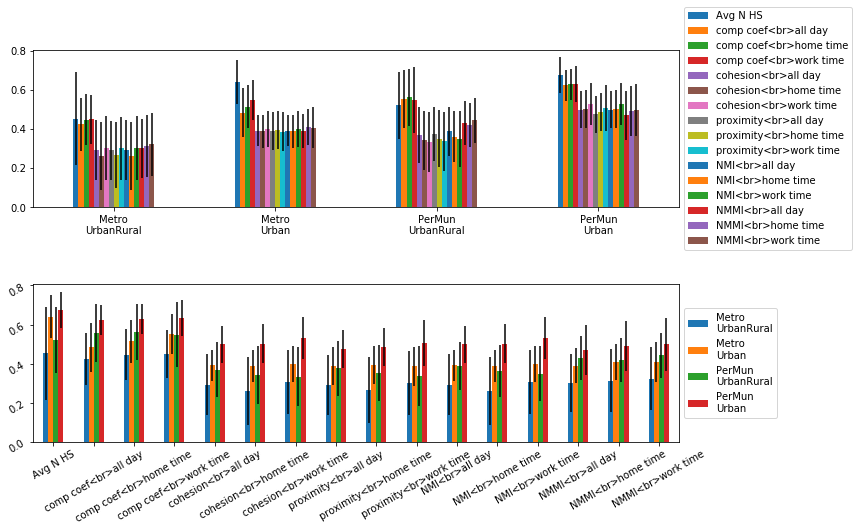

In [624]:

# corrleations = [
#     ('Comp Coef', comp_ken_tau), 
#     ('Comp Coef Work', comp_work_ken_tau), 
#     ('Comp Coef Home', comp_home_ken_tau), 
#     ('Avg N HS', nhs_ken_tau)
# ]
corrleations = [('Avg N HS', nhs_ken_tau)]+comp_ken_tau

avers, stds, display_tbl = index_level_tables(corrleations)
display(HTML(pd.DataFrame(display_tbl).style.render().replace('_','<br/>')))

fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2, 
                               figsize=(12,8))

avers_plot = pd.DataFrame(avers).T
img = avers_plot.plot(ax=ax1, kind='bar',yerr=pd.DataFrame(stds).T).legend(loc='center left', bbox_to_anchor=(1, 0.5))

avers_plot = pd.DataFrame(avers)
img = avers_plot.plot(ax=ax2, kind='bar',yerr=pd.DataFrame(stds)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=30)

plt.savefig('figs/methodLevel_KendallTau.png', bbox_inches='tight')

,"heading level0 col0"" >MetroUrbanRural","heading level0 col1"" >MetroUrban","heading level0 col2"" >PerMunUrbanRural","heading level0 col3"" >PerMunUrban"
"33ca18de16ea11eab53cd4ae52d07f78level0row0"" class=""rowheading level0 row0"" >Avg N HS","33ca18de16ea11eab53cd4ae52d07f78row0col0"" class=""data row0 col0"" >0.577 (0.271)","33ca18de16ea11eab53cd4ae52d07f78row0col1"" class=""data row0 col1"" >0.803 (0.103)","33ca18de16ea11eab53cd4ae52d07f78row0col2"" class=""data row0 col2"" >0.678 (0.179)","33ca18de16ea11eab53cd4ae52d07f78row0col3"" class=""data row0 col3"" >0.837 (0.076)"
"33ca18de16ea11eab53cd4ae52d07f78level0row1"" class=""rowheading level0 row1"" >comp coefall day","33ca18de16ea11eab53cd4ae52d07f78row1col0"" class=""data row1 col0"" >0.552 (0.167)","33ca18de16ea11eab53cd4ae52d07f78row1col1"" class=""data row1 col1"" >0.610 (0.162)","33ca18de16ea11eab53cd4ae52d07f78row1col2"" class=""data row1 col2"" >0.714 (0.167)","33ca18de16ea11eab53cd4ae52d07f78row1col3"" class=""data row1 col3"" >0.773 (0.083)"
"33ca18de16ea11eab53cd4ae52d07f78level0row2"" class=""rowheading level0 row2"" >comp coefhome time","33ca18de16ea11eab53cd4ae52d07f78row2col0"" class=""data row2 col0"" >0.577 (0.149)","33ca18de16ea11eab53cd4ae52d07f78row2col1"" class=""data row2 col1"" >0.636 (0.148)","33ca18de16ea11eab53cd4ae52d07f78row2col2"" class=""data row2 col2"" >0.718 (0.163)","33ca18de16ea11eab53cd4ae52d07f78row2col3"" class=""data row2 col3"" >0.780 (0.082)"
"33ca18de16ea11eab53cd4ae52d07f78level0row3"" class=""rowheading level0 row3"" >comp coefwork time","33ca18de16ea11eab53cd4ae52d07f78row3col0"" class=""data row3 col0"" >0.574 (0.144)","33ca18de16ea11eab53cd4ae52d07f78row3col1"" class=""data row3 col1"" >0.680 (0.125)","33ca18de16ea11eab53cd4ae52d07f78row3col2"" class=""data row3 col2"" >0.697 (0.194)","33ca18de16ea11eab53cd4ae52d07f78row3col3"" class=""data row3 col3"" >0.783 (0.098)"
"33ca18de16ea11eab53cd4ae52d07f78level0row4"" class=""rowheading level0 row4"" >cohesionall day","33ca18de16ea11eab53cd4ae52d07f78row4col0"" class=""data row4 col0"" >0.401 (0.187)","33ca18de16ea11eab53cd4ae52d07f78row4col1"" class=""data row4 col1"" >0.533 (0.104)","33ca18de16ea11eab53cd4ae52d07f78row4col2"" class=""data row4 col2"" >0.494 (0.171)","33ca18de16ea11eab53cd4ae52d07f78row4col3"" class=""data row4 col3"" >0.644 (0.106)"
"33ca18de16ea11eab53cd4ae52d07f78level0row5"" class=""rowheading level0 row5"" >cohesionhome time","33ca18de16ea11eab53cd4ae52d07f78row5col0"" class=""data row5 col0"" >0.354 (0.220)","33ca18de16ea11eab53cd4ae52d07f78row5col1"" class=""data row5 col1"" >0.529 (0.107)","33ca18de16ea11eab53cd4ae52d07f78row5col2"" class=""data row5 col2"" >0.457 (0.189)","33ca18de16ea11eab53cd4ae52d07f78row5col3"" class=""data row5 col3"" >0.648 (0.108)"
"33ca18de16ea11eab53cd4ae52d07f78level0row6"" class=""rowheading level0 row6"" >cohesionwork time","33ca18de16ea11eab53cd4ae52d07f78row6col0"" class=""data row6 col0"" >0.412 (0.194)","33ca18de16ea11eab53cd4ae52d07f78row6col1"" class=""data row6 col1"" >0.546 (0.113)","33ca18de16ea11eab53cd4ae52d07f78row6col2"" class=""data row6 col2"" >0.445 (0.189)","33ca18de16ea11eab53cd4ae52d07f78row6col3"" class=""data row6 col3"" >0.669 (0.118)"
"33ca18de16ea11eab53cd4ae52d07f78level0row7"" class=""rowheading level0 row7"" >proximityall day","33ca18de16ea11eab53cd4ae52d07f78row7col0"" class=""data row7 col0"" >0.400 (0.186)","33ca18de16ea11eab53cd4ae52d07f78row7col1"" class=""data row7 col1"" >0.534 (0.127)","33ca18de16ea11eab53cd4ae52d07f78row7col2"" class=""data row7 col2"" >0.502 (0.173)","33ca18de16ea11eab53cd4ae52d07f78row7col3"" class=""data row7 col3"" >0.619 (0.108)"
"33ca18de16ea11eab53cd4ae52d07f78level0row8"" class=""rowheading level0 row8"" >proximityhome time","33ca18de16ea11eab53cd4ae52d07f78row8col0"" class=""data row8 col0"" >0.367 (0.217)","33ca18de16ea11eab53cd4ae52d07f78row8col1"" class=""data row8 col1"" >0.539 (0.128)","33ca18de16ea11eab53cd4ae52d07f78row8col2"" class=""data row8 col2"" >0.

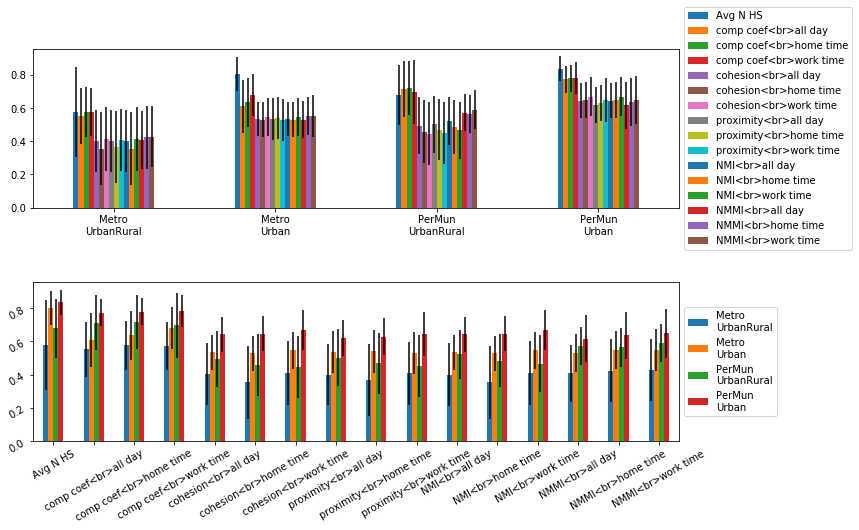

In [625]:

# corrleations = [
#     ('Comp Coef', comp_spr_rho), 
#     ('Comp Coef Work', comp_work_spr_rho), 
#     ('Comp Coef Home', comp_home_spr_rho), 
#     ('Avg N HS', nhs_spr_rho)
# ]
corrleations = [('Avg N HS', nhs_spr_rho)]+comp_spr_rho

avers, stds, display_tbl = index_level_tables(corrleations)
display(HTML(pd.DataFrame(display_tbl).style.render().replace('_time','').replace('_','<br/>')))

fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2,
                               figsize=(12,8))

avers_plot = pd.DataFrame(avers).T
img = avers_plot.plot(ax=ax1, kind='bar',yerr=pd.DataFrame(stds).T).legend(loc='center left', bbox_to_anchor=(1, 0.5))

avers_plot = pd.DataFrame(avers)
img = avers_plot.plot(ax=ax2, kind='bar',yerr=pd.DataFrame(stds)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=30)

plt.savefig('figs/methodLevel_SpearmnRho.png', bbox_inches='tight')

## intra-metro measurements

In [215]:
from collections import defaultdict

### rearrange measurements

In [764]:

def hourly_measures_per_metro(sun, geom_type, hs_stats, measure_type, idw=False):
    """
    Measures[measure names (e.g. NMMI)][key_combo (all mun_urb combo, one geom_type, all by)]
    """
    measures = defaultdict(lambda: defaultdict(list))

    for key, stats in hs_stats.items():
        if not idw:
            by, per_mun, urb_only = key
        else:
            by = '_idw10'
            per_mun, urb_only = key
        key_combo = (ADMIN_STR(per_mun, urb_only), geom_type, by)
        for hour in hs_stats[key][measure_type][sun]['hourly']:
            for mname, mvalue in hour.items():
                if mname=='hour':continue
                measures[mname][key_combo].append(mvalue)
    return measures

def hourly_measures_by_mname(geom_type, hs_stats, idws, measure_type, zms):
    """
    all_suns_measures[measure names (e.g. NMMI)][sun_id][key_combo (all mun_urb combo, all geom_type, all by)]
    """
    all_suns_measures = defaultdict(lambda : defaultdict(dict))
    for gtype, hstat, idw in zip(geom_type, hs_stats, idws):
        for sun in sorted(zms.index):
            measures = hourly_measures_per_metro(sun, gtype, hstat,measure_type,idw)
            for mname, measure in measures.items():
                all_suns_measures[mname][sun].update(measure)
    return all_suns_measures

In [765]:
measure_type = 'compactness'  # all measurements in compactness: comp_coef, cohesion, proximity, NMI, NMMI
# another type is average number of hotspot

# intra_metro_measures[measure names (e.g. NMMI)][sun_id][key_combo (all mun_urb combo, all geom_type, all by)]
intra_metro_measures = hourly_measures_by_mname(
    geom_type=['ageb', 'g.5km', 'g.5km', 'vor'],
    hs_stats=[hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor],
    idws=[False, False, True, False],
    measure_type=measure_type,
    zms=zms)

### compute correlations

In [384]:
admin_strs = [ADMIN_STR(m,u) for m in [False, True] for u in [False,True]]

In [1022]:
# ktau is run on each mun_urb combo and each measurement
astr = admin_strs[1]
ktaus_per_astr = defaultdict(dict)
print(astr)
for mname, one_measure_all_suns in intra_metro_measures.items():
    print(mname, end=' ')
    for sun, measure in one_measure_all_suns.items():
        # TODO: kendall is ill defined when a vector has no ranking (all elements are the same), e.g. sun==9
        # if sun!=9:continue
        # print(sun)
        
        # extract measure for one mun_urb combo represented as astr
        _, tau = ken_tau_corr(pd.DataFrame(measure)[astr], clean_table=False,larger_than=.0)
        if tau.isnull().values.sum()!=0:
            # 'has ill defined vectors for correlation'
            print(sun, end=' ')
            continue
        ktaus_per_astr[mname][sun] = tau
    print()
#     break
        
    

Metro_Urban
comp_coef 9 

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning:

invalid value encountered in less_equal



15 16 19 23 29 39 54 58 59 
cohesion 9 15 16 19 23 29 39 54 58 59 
proximity 9 15 16 19 23 29 39 54 58 59 
NMI 9 15 16 19 23 29 39 54 58 59 
NMMI 


### level of preservation then clustering

In [798]:
weak_tau = 0.3
strong_tau = 0.7
medium_tau = 0.5


In [802]:
def flat_triu(matrix):
    return matrix.values[np.triu_indices(len(matrix),1)]

In [1039]:
measure_type = ['comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI'][4]
ktaus = ktaus_per_astr[measure_type]

triu_ktaus = {sun:flat_triu(k) for sun, k in ktaus.items()}
triu_ktaus = pd.DataFrame(triu_ktaus).T
triu_ktaus.index.name='zm'
triu_ktaus.columns.name='ktau'

n_none = triu_ktaus.apply(lambda k: (k<weak_tau).sum(), axis=1)
n_weak = triu_ktaus.apply(lambda k: ((k>=weak_tau)&(k<medium_tau)).sum(), axis=1)
n_medium = triu_ktaus.apply(lambda k: ((k>=medium_tau)&(k<strong_tau)).sum(), axis=1)
# n_medium_above = triu_ktaus.apply(lambda k: (k>=medium_tau).sum(), axis=1)
n_strong = triu_ktaus.apply(lambda k: (k>=strong_tau).sum(), axis=1)


triu_ktaus_stats = pd.DataFrame([n_none,n_weak, n_medium, n_strong], index=['None','Weak', 'Medm', 'Strn']).T
disp_df = triu_ktaus_stats.sort_values(['Strn','Medm','Weak'],ascending=False)
disp_df = triu_ktaus_stats.reindex(list(range(1,60)))

print(astr)
print(measure_type)
display(grad_bg(disp_df, format_float=False, mask_tril=False,mini=0, maxi=21))


Metro_Urban
NMMI


,None,Weak,Medm,Strn
zm,,,,
1,14,5,2,0
2,13,1,4,3
3,14,1,5,1
4,2,4,12,3
5,15,2,3,1
6,11,5,4,1
7,15,2,4,0
8,9,5,7,0
9,17,2,2,0


In [1041]:
#
print(astr)
print(measure_type)

c = cluster.OPTICS().fit(triu_ktaus_stats)
print(c.labels_)
cluster_members = pd.DataFrame(np.unique(c.labels_, return_counts=True), index=['c','#']).T.set_index('c')


c_avg = {}
for cl in cluster_members.index.values:
#     if cl ==-1: continue
    c_avg[cl]=triu_ktaus_stats.loc[c.labels_==cl].mean().round(1).astype(str) +' ('+triu_ktaus_stats.loc[c.labels_==cl].std().round(1).astype(str) +')'

cluster_members.join(pd.DataFrame(c_avg).T)

Metro_Urban
NMMI
[ 0 -1 -1 -1  0  0  0 -1  0 -1  0 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  0  0 -1
 -1  0 -1  0 -1 -1  0 -1  0 -1  0  0  0  0  0  0 -1  0 -1  0  0  0  0 -1
  0 -1  0 -1  0  0 -1 -1  0 -1  0]


,#,None,Weak,Medm,Strn
c,,,,,
-1,29,10.3 (4.8),4.1 (3.0),4.9 (3.0),1.7 (1.6)
0,30,14.8 (1.9),3.4 (1.4),2.5 (1.2),0.4 (0.6)


In [1021]:

display(grad_bg(ktaus[4], mask_tril=True,mini=0, maxi=1))


/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



### clustering on Kendall tau matrix

In [640]:
import sklearn.cluster as cluster

In [716]:
ktaus_per_astr.keys()

dict_keys(['comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI'])

In [761]:
# clustered = cluster.AgglomerativeClustering(n_clusters=5, affinity='precomputed',linkage='average').fit(dist)
# clustered = cluster.OPTICS(metric='precomputed').fit(dist)

# default settings of minkowski distance seems to be equal to euclidean
# metric = ['braycurtis','chebyshev', 'hamming', 'minkowski'][0]
metric= ['cityblock', 'cosine', 'euclidean', 'l1', 'l2','manhattan'][1]
metric = ['canberra', 'correlation', 'sqeuclidean', ][0]
print('metric =',metric)

labels_for_each_mname = {}
for measure_name in ['comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI']:
    ktaus = ktaus_per_astr[measure_name]
    ftrs = [k.values[np.triu_indices(len(k),1)] for k in ktaus.values()]
    clustered = cluster.OPTICS(metric=metric).fit(ftrs)
    labels_for_each_mname[measure_name] = clustered.labels_
    

pd.DataFrame({k: pd.Series(v).value_counts().to_dict() for k, v in labels_for_each_mname.items()}).sort_index()

metric = canberra


,comp_coef,cohesion,proximity,NMI,NMMI
-1,41.0,NaN,28,NaN,51.0
0,8.0,49.0,9,49.0,8.0
1,NaN,NaN,6,NaN,NaN
2,NaN,NaN,6,NaN,NaN


In [778]:
measure_name = ['comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI'][2]
labels = labels_for_each_mname[measure_name]
ktaus = ktaus_per_astr[measure_name]
label_members = np.array(list(ktaus.keys()))[labels==0]
label_members

array([17, 24, 36, 42, 44, 46, 47, 51, 55])

In [779]:
swap_df = ktaus[label_members[0]]
display(grad_bg(swap_df.T.sort_index(level=0).T.sort_index(level=0), mask_tril=True,mini=0, maxi=1))

In [780]:
swap_df = ktaus[label_members[1]]
display(grad_bg(swap_df.T.sort_index(level=0).T.sort_index(level=0), mask_tril=True,mini=0, maxi=1))